### Full Name: Amir Mohammad Mehrani kia
___

# Problem
In this project  goal is to develop a framework for simple neural network and multi layer perceptron. use only `numpy` and no other packages to build our own classes and network.

# Setup

In [732]:
###################################
#  Do Not Add any other packages  #
###################################

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import copy
from abc import ABC, abstractmethod
from sklearn.datasets import fetch_openml # just for downloading the dataset (MNIST)

plt.style.use('ggplot')

# Section 1: Modules implementation (65 Points)
We are going to implement the required modules for a neural network. Each of these modules must implement the necessary functions, `_forward` and `backward`. In the following parts, we will implement the `LinearLayer`, `ReLU`, `batchnorm`, `dropout`, and `SoftMax` layers.

## Layers

In [733]:
###################################
#     Do Not change this cell     #
###################################

class Module(ABC):
    def __call__(self, *args):
        return self._forward(*args)

    @abstractmethod
    def _forward(self, *args):
        pass

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### Linear Layer (5 Points)

The `LinearLayer` class represents a linear (fully connected) layer in a neural network. This layer computes the linear transformation of the input data as Wx + b, where W is the weight matrix, x is the input data, and b is the bias vector.

In [734]:
class LinearLayer(Module):
    """
    A linear layer module that calculates (Wx + b).
    """

    def __init__(self, dim_in, dim_out, initializer, reg, alpha):
        """
        Args:
            - dim_in: input dimension,
            - dim_out: output dimension,
            - initializer: a function that takes (dim_in, dim_out) and initialize a [dim_in x dim_out] matrix,
            - reg: L2-regularization flag
            - alpha: L2-regularization coefficient
        """
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.params = {
            'W': initializer(dim_in, dim_out),
            'b': np.zeros(dim_out),
            'reg': alpha if reg else 0,
        }
        self.grads = {
            'W': np.zeros_like(self.params['W']),
            'b': np.zeros_like(self.params['b']),
        }
        self.cache = dict()

    def _forward(self, x, mode='train'):
        """
        linear forward function, calculates Wx+b for a batch of data

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            y : Wx + b
        """  
        # Perform linear transformation
        z = np.dot(x, self.params['W']) + self.params['b']
        
        # Cache the input x for backward pass
        self.cache['x'] = x
        
        return z

    def backward(self, upstream):
        """
        gets upstream gradient and returns downstream gradient

        Args:
            upstream : upstream gradient of loss w.r.t module output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        # Retrieve cached input x
        x = self.cache['x']
        
        # Gradient of loss w.r.t W
        self.grads['W'] = np.dot(x.T, upstream)
        
        # Gradient of loss w.r.t b (sum along batch axis)
        self.grads['b'] = np.sum(upstream, axis=0)
        
        # Gradient of loss w.r.t x (to pass downstream)
        grad_input = np.dot(upstream, self.params['W'].T)
        
        # Apply L2 regularization if enabled
        if self.params['reg'] > 0:
            self.grads['reg'] = self.grads['W'] + self.params['reg'] * self.params['W']
        
        # Store gradients
        self.grads['x'] = grad_input
        
        # Clean up cache
        self.cache.clear()

In [735]:
###################################
#     Do not change this cell     #
#   output must be from o(e-5)    #
###################################

def check_gradient_linear(linear, h=0.00001):
    np.random.seed(121212)
    x = np.random.normal(size=(20, linear.dim_in))
    upstream = np.random.random(size=(20, linear.dim_out))

    new_x = x + h
    new_w = linear.params['W'] + h
    new_b = linear.params['b'] + h
    new_linear = copy.deepcopy(linear)
    new_linear.params['W'] = new_w
    new_linear.params['b'] = new_b
    new_val = new_linear(new_x)
    old_val = linear(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    linear.backward(upstream)
    delta_loss_direct = np.sum(h * linear.grads['x'])
    delta_loss_direct += np.sum(h * linear.grads['W'])
    delta_loss_direct += np.sum(h * linear.grads['b'])

    print(f'Relative error of delta-loss (for linear unit):\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

    old_val = np.sum(np.power(linear.params['W'], 2))
    new_val = np.sum(np.power(new_w, 2))
    indirect_loss = new_val - old_val
    direct_loss = np.sum(h * linear.grads['reg'])
    print(f'Relative error of delta-loss (for regularization):\n{rel_error(indirect_loss, direct_loss)}')

def initializer(x, y): return np.random.normal(size=(x, y))

linear = LinearLayer(5, 10, initializer, reg=True, alpha=1)
check_gradient_linear(linear, h=0.00001)

Relative error of delta-loss (for linear unit):
2.581227600888279e-05
Relative error of delta-loss (for regularization):
0.3109389703182011


#### ReLU Layer (5 Points)

The `ReLU` class represents a Rectified Linear Unit (ReLU) activation function, which is commonly used in neural networks to introduce non-linearity. This method applies the ReLU activation function to the input data x. The ReLU function is defined as ReLU(x) = max(0, x) meaning that it outputs the input directly if it is positive, otherwise it outputs zero.

In [736]:
class ReLU(Module):
    """
    Rectified Linear Unit function
    """

    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        applies relu function on x

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            y : relu of input
        """
        # Apply ReLU function
        y = np.maximum(0, x)
        
        # Store input in cache for backward pass
        self.cache['x'] = x
        
        return y

    def backward(self, upstream):
        """
        calculate and store gradient of loss w.r.t module input

        Args:
            upstream : gradient of loss w.r.t module output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        x = self.cache['x']
        
        # Gradient of ReLU function: 1 if x > 0, else 0
        dx = upstream * (x > 0)
        
        # Store the gradient in grads
        self.grads['x'] = dx

In [737]:
###################################
#     Do not change this cell     #
#   output must be from o(e-8)    #
###################################

def check_gradient_relu(rl, h=0.0001):
    np.random.seed(11111)
    x = np.random.normal(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = rl(new_x)
    old_val = rl(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    rl.backward(upstream)
    delta_loss_direct = np.sum(h * rl.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

relu = ReLU()
check_gradient_relu(relu)

Relative error of delta-loss:
2.484727903125079e-14


#### SoftMax Layer (10 Points)

We could have a layer that calculates softmax for us. In other word, for input $x\in\mathcal{R}^N$ it would return $y\in\mathcal{R}^n$ where $y_i = \frac{e^{x_i}}{\sum e^{x_i}}$. But this method is not numerical stable because $e^{x_i}$ in this formulation can get very large easly and return `nan`. Instead of that we will implement a logarithmic version of softmax which instead of calculating $\frac{e^{x_i}}{\sum e^{x_i}}$, will calculate $\log\left(\frac{e^{x_i}}{\sum e^{x_i}}\right) = x_i - \log\sum e^{x_i}$. In order to calculate second term you can use `np.logaddexp` but this function only works on two inputs. For more than two inputs, fill in the following function to be able to calculate log sum exp of an array of shape (b,n). `axis=1` means sum over columns and `axis=0` sum over rows.

In [738]:
def logsumexp(array, axis=1):
    """
    calculate log(sum(exp(array))) using np.logaddexp

    Args:
        array : input array
        axis : reduce axis, 1 means columns and 0 means rows
    """
    # Step 1: Find the maximum value along the specified axis
    max_val = np.max(array, axis=axis, keepdims=True)
    
    # Step 2: Subtract the maximum value from the array to prevent overflow
    shifted_array = array - max_val
    
    # Step 3: Compute the exponentials of the shifted array
    exp_shifted = np.exp(shifted_array)
    
    # Step 4: Sum the exponentials along the specified axis
    sum_exp = np.sum(exp_shifted, axis=axis, keepdims=True)
    
    # Step 5: Compute the log of the sum of exponentials
    log_sum_exp = np.log(sum_exp)
    
    # Step 6: Add back the maximum value that was subtracted
    result = log_sum_exp + max_val
    
    # Remove the added dimension
    result = np.squeeze(result, axis=axis)
    
    return result

In [739]:
class LogSoftMax(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        get x and calculate softmax of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : log softmax of x with shape (b,m)
        """
        # Shift x by subtracting the maximum value for numerical stability
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        
        # Calculate softmax
        softmax = np.exp(x_shifted) / np.sum(np.exp(x_shifted), axis=1, keepdims=True)
        
        # Cache the softmax for use in backward pass
        self.cache['softmax'] = softmax
        
        # Calculate log softmax
        log_softmax = x_shifted - np.log(np.sum(np.exp(x_shifted), axis=1, keepdims=True))
        
        return log_softmax

    def backward(self, upstream):
        """
        calculate gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """ 
        # Retrieve cached softmax values
        softmax = self.cache['softmax']
        
        # Calculate gradient w.r.t input
        grad_input = upstream - np.sum(upstream, axis=1, keepdims=True) * softmax
        
        # Store gradients
        self.grads['x'] = grad_input

In [740]:
###################################
#     Do not change this cell     #
#   output must be from o(e-7)    #
###################################

def check_gradient_softmax(sm, h=0.0001):
    np.random.seed(329321)
    x = np.random.random(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = sm(new_x)
    old_val = sm(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    sm.backward(upstream)
    delta_loss_direct = np.sum(h * sm.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

sm = LogSoftMax()
check_gradient_softmax(sm)

Relative error of delta-loss:
1.0842021724855044e-11


#### BatchNorm Layer (10 Points)

The `BatchNorm` class represents a batch normalization layer, which normalizes the inputs of each mini-batch to have zero mean and unit variance, and then scales and shifts them using learned parameters.
<br>
In `train` mode, this method:
<br>
Computes the mean and variance of the current batch. Normalizes the input batch using the batch statistics. Scales and shifts the normalized batch using the `gamma` and `beta` parameters. Updates the running mean and variance using the computed batch statistics.
<br>
In `valid` or `test` mode, this method:
<br>
Normalizes the input batch using the running mean and variance. Scales and shifts the normalized batch using the `gamma` and `beta` parameters.

In [741]:
import numpy as np

class BatchNorm(Module):
    def __init__(self, dim_in, momentum=0.99, eps=1e-3):
        """
        Batch normalization layer for neural networks.

        Args:
            dim_in: Input dimension.
            momentum: Momentum for moving average of mean and variance.
            eps: Small constant to prevent division by zero.
        """
        self.cache = dict()
        self.grads = dict()
        self.momentum = momentum
        self.eps = eps
        self.dim_in = dim_in
        self.params = {
            'gamma': np.ones(dim_in),
            'beta': np.zeros(dim_in),
            'running_mean': np.zeros(dim_in),
            'running_var': np.zeros(dim_in),
        }

    def _forward(self, x, mode='train'):
        """
        Forward pass for batch normalization layer.

        Args:
            x: Batch of data with shape (b, m)
            mode: The step of training which can be 'train', 'valid' or 'test'

        Returns:
            y: Batch normalized data with shape (b, m)
        """
        gamma = self.params['gamma']
        beta = self.params['beta']
        running_mean = self.params['running_mean']
        running_var = self.params['running_var']

        if mode == 'train':
            batch_mean = np.mean(x, axis=0)
            batch_var = np.var(x, axis=0)
            
            normalized_x = (x - batch_mean) / np.sqrt(batch_var + self.eps)
            out = gamma * normalized_x + beta
            
            # Update running statistics
            running_mean = self.momentum * running_mean + (1 - self.momentum) * batch_mean
            running_var = self.momentum * running_var + (1 - self.momentum) * batch_var
            
            # Store intermediate values needed for backward pass
            self.cache['x'] = x
            self.cache['normalized_x'] = normalized_x
            self.cache['batch_mean'] = batch_mean
            self.cache['batch_var'] = batch_var
        else:
            normalized_x = (x - running_mean) / np.sqrt(running_var + self.eps)
            out = gamma * normalized_x + beta

        self.params['running_mean'] = running_mean
        self.params['running_var'] = running_var

        return out

    def backward(self, upstream):
        """
        Backward pass for batch normalization layer.

        Args:
            upstream: Gradient of loss w.r.t module output with shape (b, m)

        Note:
            Calculate gradient of loss w.r.t module input and parameters and store them in grads.
        """
        x = self.cache['x']
        normalized_x = self.cache['normalized_x']
        batch_mean = self.cache['batch_mean']
        batch_var = self.cache['batch_var']
        gamma = self.params['gamma']
        eps = self.eps

        N, D = x.shape

        # Gradients of beta and gamma
        dbeta = np.sum(upstream, axis=0)
        dgamma = np.sum(upstream * normalized_x, axis=0)
        
        # Intermediate partial derivatives
        dxhat = upstream * gamma
        dvar = np.sum(dxhat * (x - batch_mean) * -0.5 * (batch_var + eps)**-1.5, axis=0)
        dmean = np.sum(dxhat * -1 / np.sqrt(batch_var + eps), axis=0) + dvar * np.mean(-2 * (x - batch_mean), axis=0)
        
        # Gradient of the input x
        dx = (dxhat / np.sqrt(batch_var + eps)) + (dvar * 2 * (x - batch_mean) / N) + (dmean / N)

        self.grads['gamma'] = dgamma
        self.grads['beta'] = dbeta
        self.grads['x'] = dx


#### Dropout Layer (5 Points)

The `Dropout` class represents a dropout layer, which randomly sets a fraction of input units to zero during training to prevent overfitting.
<br>
In `train` mode, this method:
<br>
Randomly sets a fraction of input units to zero with probability `prob`.
<br>
In `valid` or `test` mode, this method:
<br>
Returns the input data unchanged.

In [742]:
class Dropout(Module):
    def __init__(self, prob=0.5):
        """
        Dropout layer for neural networks.

        Args:
            prob: Probability of dropping out a neuron.
        """
        self.cache = dict()
        self.grads = dict()
        self.prob = prob

    def _forward(self, x, mode='train'):
        """
        Forward pass of dropout layer.

        Args:
            x: Input batch of data with shape (b, m).
            mode: 'train', 'val', or 'test'.

        Returns:
            y: Output after applying dropout with shape (b, m).
        """
        if mode == 'train':
            # Generate dropout mask
            dropout_mask = np.random.rand(*x.shape) < self.prob
            # Scale output during training to maintain expected value
            y = x * dropout_mask / (1 - self.prob)
            # Cache dropout mask for backward pass
            self.cache['dropout_mask'] = dropout_mask
        elif mode == 'val' or mode == 'test':
            # During validation/test, just pass through input
            y = x
        else:
            raise ValueError(f"Invalid mode '{mode}'. Mode must be 'train', 'val', or 'test'.")
        
        return y

    def backward(self, upstream):
        """
        Backward pass of dropout layer.

        Args:
            upstream: Gradient of loss with respect to the output of this layer.

        Returns:
            Gradient of loss with respect to the input of this layer.
        """
        dropout_mask = self.cache['dropout_mask']
        # Scale gradients by dropout mask during training
        dx = upstream * dropout_mask / (1 - self.prob)
        self.grads['x'] = dx

## Model (5 Points)
We need a model class which gathers our layers togather and performs forward and backward on all of them.

In [743]:
class MLPModel(Module):
    mode = 'train'
    """
    A multilayer neural network model
    """

    def __init__(self, layers):
        """
        Args:
            layers : list of model layers
        """
        self.layers = layers

    def _forward(self, x):
        """
        Performs forward on x

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            o : model output
        """
        for layer in self.layers:
            x = layer._forward(x, mode=self.mode)
        return x

    def backward(self, upstream):
        """
        Perform backward path on whole model

        Args:
            upstream : gradient of loss w.r.t model output
        """
        for layer in reversed(self.layers):
            layer.backward(upstream)
            upstream = layer.grads['x']
            threshold = 100
            for grad in layer.grads:
                np.clip(layer.grads[grad], -threshold, threshold, out=layer.grads[grad])


        return upstream

    def get_parameters(self):
        """
        Returns:
            parametric_layers: List of layers with trainable parameters.
        """
        parametric_layers = []
        for layer in self.layers:
            if hasattr(layer, 'params'):
                parametric_layers.append(layer)
        return parametric_layers
    
    def clone(self):
        import pickle
        import os

        with open('best_model.pkl', 'wb') as f:
            pickle.dump(self, f)
            if os.path.exists('best_model.pkl'):
                with open('best_model.pkl', 'rb') as f:
                    cloned_model = pickle.load(f)
            else:
                # Handle the case where no best model has been saved yet
                cloned_model = None  # or any other initialization you prefer
        return cloned_model

## Loss functions (10 Points)
We need to implement loss functions to be able to train our network. We will implement CrossEntropy loss function. But notice that we have implemented `LogSoftMax` in logarithmic way so input of the following class will be logarithm of probabilities.
<br>
The `CrossEntropyLoss` class represents the cross-entropy loss function, which is commonly used in classification tasks to measure the difference between predicted probabilities and true labels. This method calculates the cross-entropy loss between the predicted probabilities (converted to log probabilities) and the true labels. The cross-entropy loss is computed using the formula: $ -\frac{1}{b} \sum_{i=1}^{b} \log(p_{i, \text{target}_i}) $, where the value inside the parentheses is the predicted probability of the correct class for the ith sample.

In [744]:
class CrossEntropyLoss(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, logprobs, targets):
        """
        Calculate cross entropy of inputs.

        Args:
            logprobs : matrix of log probabilities with shape (b,n)
            targets : list of sample classes with shape (b,)

        Returns:
            y : cross entropy loss
        """
        self.cache['logprobs'] = logprobs
        self.cache['targets'] = targets
        b, n = logprobs.shape
        loss = 0

        for i in range(b):
            loss -= logprobs[i, targets[i]]
        return loss / b

    def backward(self, upstream):
        """
        Calculate gradient of loss w.r.t module input and save them in grads.

        Args:
            upstream : gradient of loss w.r.t module output (loss)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        b, n = self.cache['logprobs'].shape
        grads = np.zeros_like(self.cache['logprobs'])
        for i in range(b):
            grads[i, self.cache['targets'][i]] = -1/b
        self.grads['x'] = grads * upstream

In [745]:
###################################
#     Do not change this cell     #
#   output must be from o(e-10)   #
###################################

def check_gradient_ce(ce, h=0.0001):
    np.random.seed(123123)
    target = np.random.randint(5, size=10)
    probs = np.random.random(size=(10, 5))
    upstream = 1

    new_probs = probs + h
    new_val = ce(new_probs, target)
    old_val = ce(probs, target)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    ce.backward(upstream)
    delta_loss_direct = np.sum(h * ce.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

ce = CrossEntropyLoss()
check_gradient_ce(ce, h=0.0001)

Relative error of delta-loss:
6.102702978381506e-13


## Optimization (15 Points)

Now that we have our network and loss function, we need to update model paremeters. We can do so by using `Optimizer` class that perform updating rule on model parameters. You need to implement `sgd`, `adam` and `momentum` strategy for this optimizers. Becareful to consider regularization update for linear units that require regularization.
<br>
SGD:
<br>
$$
\theta = \theta - \eta \cdot \nabla_{\theta}J(\theta)
$$
<br>

Momentum:
<br>
$$
\begin{aligned}
v &= \mu \cdot v - \eta \cdot \nabla_{\theta}J(\theta) \\
\theta &= \theta + v
\end{aligned}
$$
<br>

Adam:
<br>
\begin{align*}
m_t &= \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla_{\theta}J(\theta) \\
v_t &= \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla_{\theta}J(\theta))^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta &= \theta - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align*}

In [746]:
import numpy as np

class Optimizer():
    """
    Our main optimization class.

    You can add arguments to _sgd and _momentum function if you need to do so, and
    pass this arguments to step function when using optimizer. Don't change __init__
    or step function.
    """

    def __init__(self, layers, strategy, lr):
        """
        Initialize the optimizer.

        Args:
            layers: Model layers (those whose parameters we want to update).
            strategy: Optimization strategy ('sgd', 'momentum', or 'adam').
            lr (callable): Learning rate function that takes the epoch as input.
        """
        self.layers = layers
        self.strategy = strategy
        self.lr = lr
        self.strategies = {
            'sgd': self._sgd,
            'momentum': self._momentum,
            'adam': self._adam,
        }
        self.momentum_changes = dict([])

    def step(self, *args):
        """
        Perform the specified update strategy on all layer parameters.

        Args:
            *args: Additional arguments specific to the chosen strategy.
        """
        self.strategies[self.strategy](*args)

    def _sgd(self, epoch):
        """
        Perform stochastic gradient descent update on layer parameters.

        Args:
            epoch: Current training epoch.
        """
        for layer in self.layers:
            for param_name in layer.params:
                if param_name == 'reg':
                    continue  # Skip regularization parameter
                if param_name not in layer.grads:
                    continue
                gradient = layer.grads[param_name]
                learning_rate = self.lr(epoch)
                # Update parameter
                layer.params[param_name] -= learning_rate * gradient

    def _momentum(self, epoch, momentum=0.9):
        """
        Perform momentum update on layer parameters.

        Args:
            epoch: Current training epoch.
            momentum: Momentum coefficient.
        """
        for layer in self.layers:
            for param_name in layer.params:
                if param_name == 'reg':
                    continue  # Skip regularization parameter
                if param_name not in layer.grads:
                    continue
                gradient = layer.grads[param_name]
                key = (id(layer), param_name)
                if key not in self.momentum_changes:
                    self.momentum_changes[key] = np.zeros_like(gradient)
                # Update momentum
                self.momentum_changes[key] = momentum * self.momentum_changes[key] + gradient
                # Update parameter
                learning_rate = self.lr(epoch)
                layer.params[param_name] -= learning_rate * self.momentum_changes[key]

    def __momentum_change(self, momentum, key, value):
        """
        Update momentum for a specific parameter.

        Args:
            momentum: Current momentum coefficient.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated momentum value.
        """
        if key not in self.momentum_changes:
            self.momentum_changes[key] = np.zeros_like(value)
        # Update momentum
        self.momentum_changes[key] = momentum * self.momentum_changes[key] + value
        return self.momentum_changes[key]

    def _adam(self, epoch, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        Perform Adam update on layer parameters.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
        """
        t = epoch + 1  # Epoch starts from 0, t starts from 1
        for layer in self.layers:
            for param_name in layer.params:
                if param_name == 'reg':
                    continue  # Skip regularization parameter
                if param_name not in layer.grads:
                    continue
                gradient = layer.grads[param_name]
                key = (id(layer), param_name)
                m_key = key + ('m',)
                v_key = key + ('v',)
                if m_key not in self.momentum_changes:
                    self.momentum_changes[m_key] = np.zeros_like(gradient)
                if v_key not in self.momentum_changes:
                    self.momentum_changes[v_key] = np.zeros_like(gradient)
                # Update biased first moment estimate
                self.momentum_changes[m_key] = beta1 * self.momentum_changes[m_key] + (1 - beta1) * gradient
                # Update biased second raw moment estimate
                self.momentum_changes[v_key] = beta2 * self.momentum_changes[v_key] + (1 - beta2) * (gradient ** 2)
                # Compute bias-corrected first moment estimate
                m_hat = self.momentum_changes[m_key] / (1 - beta1 ** t)
                # Compute bias-corrected second raw moment estimate
                v_hat = self.momentum_changes[v_key] / (1 - beta2 ** t)
                # Update parameter
                learning_rate = self.lr(epoch)
                layer.params[param_name] -= learning_rate * m_hat / (np.sqrt(v_hat) + eps)

    def __adam_change(self, epoch, beta1, beta2, eps, key, value):
        """
        Update Adam parameters for a specific parameter.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated parameter value.
        """
        t = epoch + 1  # Epoch starts from 0, t starts from 1
        m_key = key + ('m',)
        v_key = key + ('v',)
        if m_key not in self.momentum_changes:
            self.momentum_changes[m_key] = np.zeros_like(value)
        if v_key not in self.momentum_changes:
            self.momentum_changes[v_key] = np.zeros_like(value)
        # Update biased first moment estimate
        self.momentum_changes[m_key] = beta1 * self.momentum_changes[m_key] + (1 - beta1) * value
        # Update biased second raw moment estimate
        self.momentum_changes[v_key] = beta2 * self.momentum_changes[v_key] + (1 - beta2) * (value ** 2)
        # Compute bias-corrected first moment estimate
        m_hat = self.momentum_changes[m_key] / (1 - beta1 ** t)
        # Compute bias-corrected second raw moment estimate
        v_hat = self.momentum_changes[v_key] / (1 - beta2 ** t)
        # Return updated parameter value
        return m_hat / (np.sqrt(v_hat) + eps)

# Section 2: MNIST Classification (35 Points)

Now that we can build a neural network we want to solve MNIST classification problem. This dataset consists of 70000 $28 \times 28$ grayscale images in 10 classes.

## Data preparation (5 Points)

In [747]:
# Download MNIST dataset from openml
mnist = fetch_openml('mnist_784', version=1)

# Extract features (X) and labels (y)
X = mnist.data
y = mnist.target.astype(int)

/home/amoohashem/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [748]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the original training set into a new training set and a validation set
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


# Print the shapes to verify the split
print(f"X_train shape: {X_train_new.shape}, y_train shape: {y_train_new.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (44800, 784), y_train shape: (44800,)
X_val shape: (11200, 784), y_val shape: (11200,)
X_test shape: (14000, 784), y_test shape: (14000,)


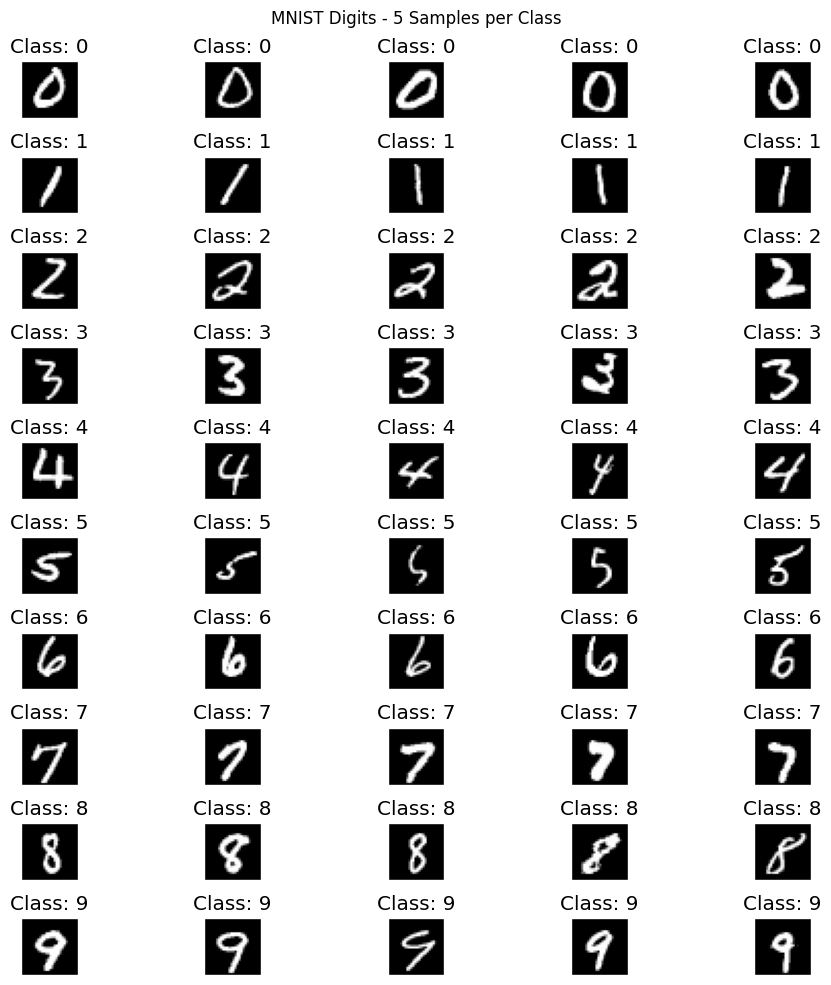

In [749]:
# Define the number of samples per class
num_samples_per_class = 5

# Create a figure for plotting
fig, axes = plt.subplots(10, num_samples_per_class, figsize=(10, 10))

# Loop through each class (0-9)
for class_idx in range(10):
  # Filter images and labels for the current class
  X_class = X_train[y_train == class_idx]

  # Randomly select num_samples_per_class images
  random_indices = np.random.choice(X_class.shape[0], num_samples_per_class)
  X_class_subset = X_class[random_indices]

  # Plot each image in a subplot
  for i in range(num_samples_per_class):
    image = X_class_subset[i].reshape(28, 28)  # Reshape for plotting
    axes[class_idx, i].imshow(image, cmap='gray')
    axes[class_idx, i].set_xticks([])
    axes[class_idx, i].set_yticks([])
    axes[class_idx, i].set_title(f"Class: {class_idx}")

# Adjust layout and show the plot
fig.suptitle(f"MNIST Digits - {num_samples_per_class} Samples per Class", fontsize=12)
plt.tight_layout()
plt.show()

Now normalize the data (mean=0 and std=1) and also flattern the input because we have just linear layers and we need to have a vector as input.

In [750]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the images from 28x28 to 784
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("X_train_flattened shape:", X_train_flattened.shape)
print("X_test shape:", X_test.shape)
print("X_test_flattened shape:", X_test_flattened.shape)

X_train shape: (56000, 784)
X_train_flattened shape: (56000, 784)
X_test shape: (14000, 784)
X_test_flattened shape: (14000, 784)


## Train and Test Model (35 Points)

### Batch Sampler (10 Points)
We need to sample bathces from our dataset to train model. Complete the following class to have a random sampler (8 Points).

In [751]:
import random

class RandomSampler(object):
    def __init__(self, batch_size, dataset):
        """
        Args:
            batch_size : sampler batch size
            dataset : dataset we want to get batch from that
            dtype : one of {'train', 'test', 'val'}
        """
        self.batch_size = batch_size
        self.dataset = dataset

        # Filter dataset based on dtype
        self.data = [(x, y) for x, y in dataset]

    def __len__(self):
        return len(self.data) // self.batch_size

    def __iter__(self):
        """
        This function is called when we iterate an object of this class and
        yields one batch on each call.

        Yields:
            (x, y) : tuple of batches of x and y
        """
        #######################################################
        ##  Yield a tuple of x and y from specified dataset  ##
        #####################[Your Code]#######################
        
        data_copy = self.data.copy()
        random.shuffle(data_copy)
        
        for i in range(0, len(data_copy), self.batch_size):
            batch = data_copy[i:i + self.batch_size]
            if len(batch) == self.batch_size:  # Ensure full batches only
                x_batch, y_batch = zip(*[(x, y) for x, y in batch])
                yield x_batch, y_batch


Fill the following functions to update a confusion matrix and calculate f1 score for a confusion matrix (2 Points).

In [752]:
def update_confusion_matrix(conf_matrix, preds, reals):
    """
    Updates confusion matrix

    Args:
        conf_matrix : input confusion matrix
        preds : array of predicted labels
        reals : array of real labels

    Returns:
        conf_matrix : updated confusion matrix
    """
    for real, pred in zip(reals, preds):
        conf_matrix[real][pred] += 1
    return conf_matrix


def f1_score(confusion_matrix):
    """
    Calculate macro F1 score from given confusion matrix

    Args:
        confusion_matrix : given confusion matrix

    Returns:
        f1 : macro F1 score
    """
    num_classes = len(confusion_matrix)
    f1_scores = []

    for i in range(num_classes):
        # True Positives (TP)
        tp = confusion_matrix[i][i]
        
        # False Positives (FP)
        fp = sum(confusion_matrix[j][i] for j in range(num_classes)) - tp
        
        # False Negatives (FN)
        fn = sum(confusion_matrix[i][j] for j in range(num_classes)) - tp
        
        # Precision and Recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 Score
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1_scores.append(f1)

    # Macro F1 Score
    macro_f1 = sum(f1_scores) / num_classes

    return macro_f1

### Define Model (5 Points)
Define an MLP model to solve the classification problem. Try to define a good initializer function (not just a simple random initializer)

In [753]:
import numpy as np

def initializer(x, y):
    """
    Xavier (Glorot) initialization for weights.

    Args:
        x : int, number of input units
        y : int, number of output units

    Returns:
        np.ndarray, initialized weights
    """
    limit = np.sqrt(6.0 / (x + y))
    weights = np.random.uniform(-limit, limit, size=(x, y))
    return weights

model = MLPModel([
    LinearLayer(dim_in=784, dim_out=256, initializer=initializer, reg=True, alpha=0.001),
    BatchNorm(dim_in=256, momentum=0.9, eps=1e-5),
    ReLU(),
    Dropout(prob=0.4),
    LinearLayer(dim_in=256, dim_out=128, initializer=initializer, reg=True, alpha=0.001),
    BatchNorm(dim_in=128, momentum=0.9, eps=1e-5),
    ReLU(),
    Dropout(prob=0.3),
    LinearLayer(dim_in=128, dim_out=10, initializer=initializer, reg=True, alpha=0.001),
    LogSoftMax()
])

In [754]:
#######################################################
##           Initialize hyperparameters              ##
#####################[Your Code]#######################

n_epochs = 20  # Example: number of epochs
batch_size = 256  # Example: batch size

def lr(epoch):
    initial_lr = 0.01  # Example: initial learning rate
    decay_rate = 0.1  # Example: rate at which to decrease learning rate
    decay_steps = 10  # Example: number of epochs after which to decay learning rate
    
    if epoch < decay_steps:
        return initial_lr
    else:
        return initial_lr * decay_rate

In [755]:
##################################################
## Define optimizer, loss and sampler (1 Point) ##
##################[Your Code]#####################

optimizer = Optimizer(model.get_parameters(), strategy='sgd', lr=lr)

criterion = CrossEntropyLoss()

# I dont use Sampler! so I didn't define it.

### Train Model (17 Points)

Fill in the below cell to train the model. Store each epoch loss, accuracy and f1-score. Use f1-score to choose best epoch.

**Note1**: To do backpropagation you need to first call `backward` function of criterion with 1 as its argument to have gradient of loss w.r.t output of this module and then using model `backward` function with `criterion.grads['x']` argument.

**Note2**: You can ignore regularization term in your total loss value and just use criterion, but you must consider that during updating.

In [756]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1, val_f1 = [], []
lrs = []
best_model = None
best_f1 = 0
output_size = 10

for epoch in range(n_epochs):
    ##################################################
    ##                 Train Phase                  ##
    ##################################################
    model.mode = 'train'
    train_loss = 0
    conf_matrix_train = np.zeros((output_size, output_size), dtype=int)
    
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        train_loss += loss
        
        # # Backward pass: compute gradients
        # model.zero_gradients()  # Clear accumulated gradients
        # loss_gradients = loss.backward()  # Compute gradients

        # Update weights using the optimizer
        criterion.backward(1)
        model.backward(criterion.grads['x'])
        optimizer.step(epoch)

        # Update confusion matrix
        preds = np.argmax(outputs, axis=1)
        conf_matrix_train = update_confusion_matrix(conf_matrix_train, preds, y_batch)
    
    train_loss /= len(X_train) / batch_size
    train_losses.append(train_loss)
    
    # Calculate accuracy and F1 score
    train_acc = np.trace(conf_matrix_train) / np.sum(conf_matrix_train)
    train_accs.append(train_acc)
    train_f1_score = f1_score(conf_matrix_train)
    train_f1.append(train_f1_score)
    lrs.append(lr(epoch))

    
    ##################################################
    ##               Validation Phase               ##
    ##################################################
    model.mode = 'val'
    val_loss = 0
    conf_matrix_val = np.zeros((output_size, output_size), dtype=int)
    
    for i in range(0, len(X_val), batch_size):
        X_batch = X_val[i:i + batch_size]
        y_batch = y_val[i:i + batch_size]

        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        val_loss += loss

        # Update confusion matrix
        preds = np.argmax(outputs, axis=1)
        conf_matrix_val = update_confusion_matrix(conf_matrix_val, preds, y_batch)
    
    val_loss /= len(X_val) / batch_size
    val_losses.append(val_loss)
    
    # Calculate accuracy and F1 score
    val_acc = np.trace(conf_matrix_val) / np.sum(conf_matrix_val)
    val_accs.append(val_acc)
    val_f1_score = f1_score(conf_matrix_val)
    val_f1.append(val_f1_score)
    
    ##################################################
    ##          Save best model and best f1         ##
    ##################################################
    if val_f1_score > best_f1:
        best_f1 = val_f1_score
        best_model = model.clone()

    print(f"Epoch {epoch + 1}/{n_epochs} - "
          f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
          f"Train F1: {train_f1_score:.4f} - Val F1: {val_f1_score:.4f}")

print("Training complete.")

Epoch 1/20 - Train Loss: 2.2015 - Val Loss: 1.0639 - Train F1: 0.2068 - Val F1: 0.6350
Epoch 2/20 - Train Loss: 1.7626 - Val Loss: 0.7902 - Train F1: 0.3921 - Val F1: 0.7234
Epoch 3/20 - Train Loss: 1.5081 - Val Loss: 0.6874 - Train F1: 0.5058 - Val F1: 0.7598
Epoch 4/20 - Train Loss: 1.3344 - Val Loss: 0.6236 - Train F1: 0.5766 - Val F1: 0.7869
Epoch 5/20 - Train Loss: 1.2033 - Val Loss: 0.5877 - Train F1: 0.6290 - Val F1: 0.8082
Epoch 6/20 - Train Loss: 1.1000 - Val Loss: 0.5563 - Train F1: 0.6658 - Val F1: 0.8265
Epoch 7/20 - Train Loss: 1.0159 - Val Loss: 0.5398 - Train F1: 0.6933 - Val F1: 0.8419
Epoch 8/20 - Train Loss: 0.9502 - Val Loss: 0.5265 - Train F1: 0.7180 - Val F1: 0.8530
Epoch 9/20 - Train Loss: 0.8994 - Val Loss: 0.5166 - Train F1: 0.7324 - Val F1: 0.8605
Epoch 10/20 - Train Loss: 0.8470 - Val Loss: 0.5077 - Train F1: 0.7487 - Val F1: 0.8673
Epoch 11/20 - Train Loss: 0.8251 - Val Loss: 0.5079 - Train F1: 0.7567 - Val F1: 0.8682
Epoch 12/20 - Train Loss: 0.8221 - Val Lo

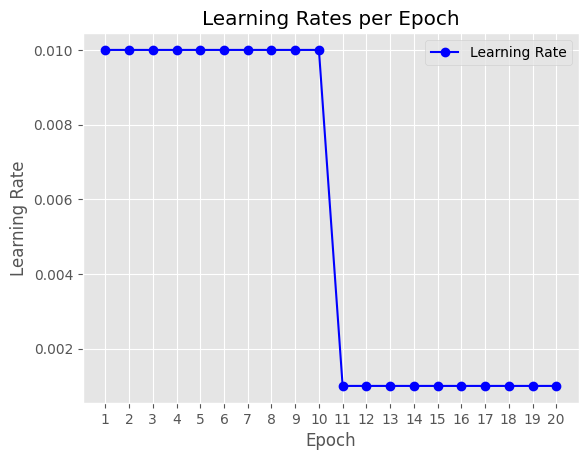

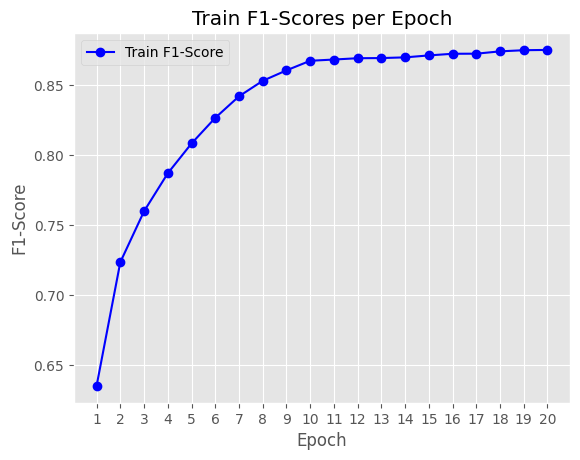

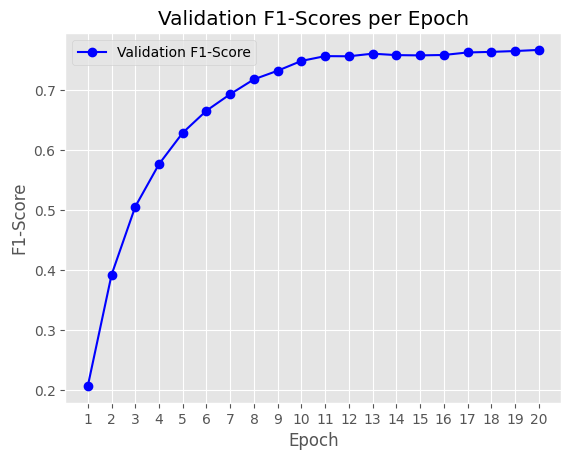

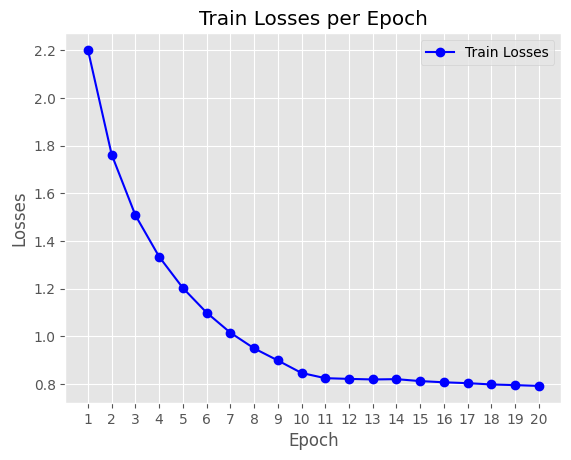

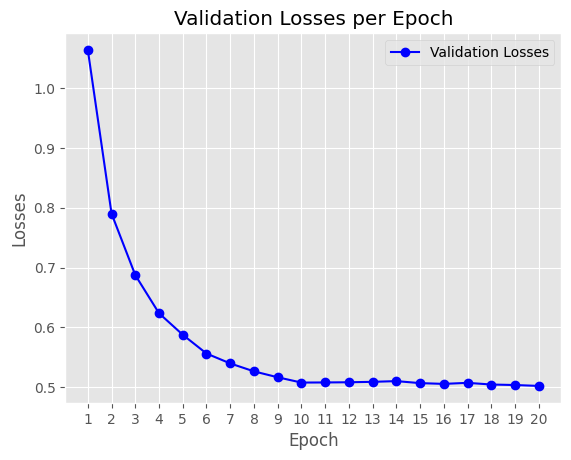

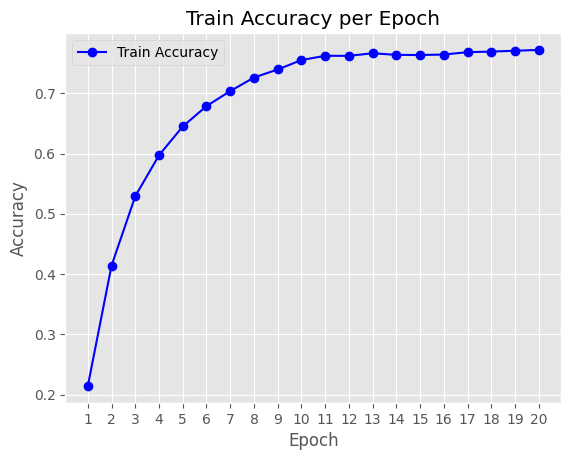

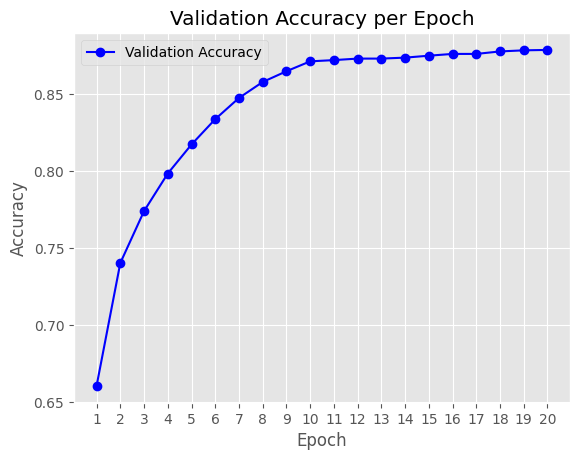

In [757]:
##################################################################################################
## Plot train and validation loss, accuracy and f1 graphs and lr value at each epoch (2 Points) ##
#######################################[Your Code]################################################

def my_plot(x, y, title, x_label, y_label, line_label):
  plt.plot(x, y, marker='o', linestyle='-', color='b', label=line_label)
  plt.title(title)
  plt.xlabel(x_label,)
  plt.ylabel(y_label)
  plt.xticks(x)
  plt.grid(True)
  plt.legend()
  plt.show()

epochs = range(1, len(train_accs) + 1)

my_plot(epochs, lrs, 'Learning Rates per Epoch', 'Epoch', 'Learning Rate', 'Learning Rate')

my_plot(epochs, val_f1, 'Train F1-Scores per Epoch', 'Epoch', 'F1-Score', 'Train F1-Score')
my_plot(epochs, train_f1, 'Validation F1-Scores per Epoch', 'Epoch', 'F1-Score', 'Validation F1-Score')

my_plot(epochs, train_losses, 'Train Losses per Epoch', 'Epoch', 'Losses', 'Train Losses')
my_plot(epochs, val_losses, 'Validation Losses per Epoch', 'Epoch', 'Losses', 'Validation Losses')

my_plot(epochs, train_accs, 'Train Accuracy per Epoch', 'Epoch', 'Accuracy', 'Train Accuracy')
my_plot(epochs, val_accs, 'Validation Accuracy per Epoch', 'Epoch', 'Accuracy', 'Validation Accuracy')

### Test Model (3 Points)

Accuracy: 0.8788
F1 Score: 0.8769
Loss: 0.4329


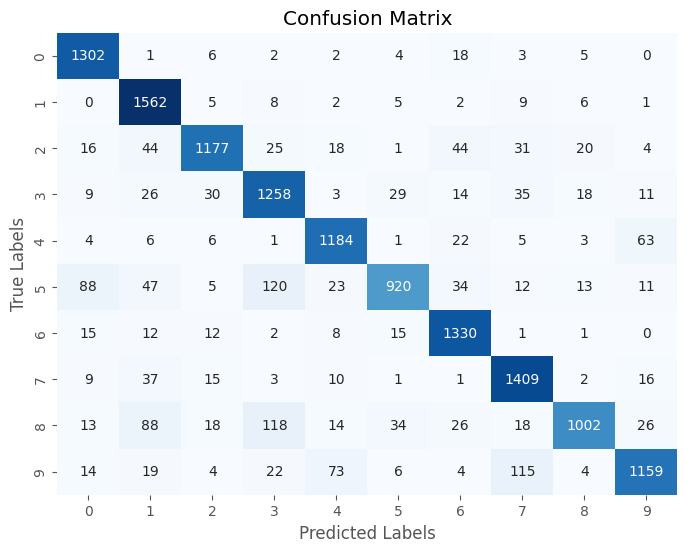

In [758]:
############################################################
##                  Test your best model                  ##
##          Report loss, accuracy and f1 metrics          ##
##      Also plot the confusion matrix for test data      ##
#######################[Your Code]##########################

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_prob = best_model(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Compute loss
loss = criterion(outputs, y_batch)

# Report accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Loss: {loss:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()